# Mutual inclinations of binary stars and their circumbinary disks

*This notebook explores some concepts that will appear in a paper we are working on about circumbinary disks.*

Here's a pretty straightforward question that turns out to have not-such-a-straightforward answer. Let's say we have measurements of the inclination of a binary star orbit and its circumbinary disk relative to the sky plane, $i_\star$ and $i_\mathrm{disk}$. And, let's say that these are pretty similar, like $i_\star = 33.42^\circ \pm 0.01^\circ$ and $i_\mathrm{disk} = 33.5^\circ \pm 1.4^\circ$ (as in V4046 Sgr system, [for example](https://ui.adsabs.harvard.edu/#abs/2012ApJ...759..119R/abstract)). How misaligned are the circumbinary disk and the plane of the binary orbit, i.e., what's their mutual inclination? You might say the fact that

$$
|i_\mathrm{disk} - i_\star| = |33.5^\circ - 33.42^\circ| < 0.1^\circ
$$

means that these planes are pretty much coplanar. However, that's not the full story because $i$ just tells us the inclination of each orbit relative to the sky plane and we need to know the position angle of the ascending node $\Omega$ to actually visualize the orbit in 3D space. Given both measurements of $i$ and $\Omega$ for both the binary star orbit and its circumbinary disk, we can calculate the mutual inclination $\Delta I$ between the two as

$$
\cos (\Delta I) = \cos i_\mathrm{disk} \cos i_\star + \sin i_\mathrm{disk} \sin i_\star \cos(\Omega_\mathrm{disk} - \Omega_\star).
$$

For a growing sample of binary stars with double-lined radial velocity solutions and circumbinary protoplanetary disks resolved by ALMA, we generally have precise constraints on $i_\mathrm{disk}$, $\Omega_\mathrm{disk}$, and $i_\star$, but no constraint on $\Omega_\star$. Therefore, we are unable to directly solve for $\Delta I$. 

To make this problem concrete, let's consider V4046 Sgr, which in addition to the inclinations quoted, also has $\Omega_\mathrm{disk} = 256^\circ \pm 1.0^\circ$. Our goal is to use the measurements of these three parameters to determine the posterior probability distribution of the mutual inclination. 

First, we'll walk through the example of V4046 Sgr using a typical Bayesian approach making what seem like reasonable assumptions, and end up with a counter-intuitive result. Then, we'll introduce a hierarchical model that includes a parameterization of the mutual inclination distribution. To test this, we'll make two samples of fake data, one with intrinsically low mutual inclinations and one with isotropically randomly oriented orbits. Finally, we'll use our model to see if we correctly infer the input distributions. 

## Inferring $\Delta I$ for one disk

Let's write down a posterior distribution for $\Delta I$ given the information about the V4046 Sgr system that we just listed. To do this we'll come up with a joint posterior distribution for the 4 binary and disk parameters $i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star$ and then use samples from this posterior and the mutual inclination formula to calculate the posterior distribution of $\Delta I$.

We'll need to write down a likelihood function and a set of priors. We'll start with the priors and make an assumption that both the disk and the binary orbit can be randomly oriented in 3D space. This means that the unit angular momentum vector of the orbit has uniform probability of pointing anywhere on the unit sphere. This translates into a prior probability distribution on the orbital parameters of

$$
p(i, \Omega) = \frac{\sin i}{2},
$$

Which is a uniform distribution in position angle ($\Omega$) from [0,360] degrees and a $\sin i$ taper on the inclination. This is because there's less surface area at higher latitudes on the unit sphere.

Let's denote the measured parameters of V4046 Sgr with a hat, $\hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star}$. For most systems, these parameters are highly constrained with Gaussian uncertainties and with minimum covariances between parameters. Therefore, we will use a multivariate normal as our likelihood function

$$ p( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star ) = {\cal N}( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star, \boldsymbol{\Sigma})$$

e.g., this is just a multivariate Gaussian centered on $\hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star}$, and the shape of the Gaussian is described by the covariance matrix $\boldsymbol{\Sigma}$. There are more parameters to this Gaussian (like $\Omega_\star$), but since we don't have data on this parameter, there are only three dimensions to the Gaussian likelihood function.


We can combine both of these to write down an (unnormalized) posterior probability distribution 

$$ p(i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star | \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star})  = p( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star ) \frac{\sin i_\mathrm{disk} \sin i_\star}{4}
$$

We will use MCMC to sample this posterior distribution and then use the mutual inclination formula to convert these samples to a posterior on $\Delta I$.

Let's start by importing some packages that will help us solve this problem, such as the normal ones like numpy and matplotlib, but also PyMC3 and Theano (it's foundation). We could just as easily do this using packages more familiar to astronomers (like emcee), but to solve the hierarchical problem we'll want to take advantage of some of the more powerful features of probabilistic programming languages like PyMC3.

In [1]:
# code here
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

import numpy as np
import theano.tensor as tt
import pymc3 as pm

import matplotlib.pyplot as plt

deg = np.pi/180.0

In [2]:
# When sampling distributions it helps to make sensible (well-behaved) choices of parameterizations. 
# For this reason we are using the cosine of inclination and all angles are in radians.
data = np.array([np.cos(33.5 * deg), 256.0 * deg, np.cos(33.42 * deg)])
    
# We've also converted the inclination uncertainties to cos() via propagation of error 
# sigma_cos_i = sin(i) * sigma_i (where sigma_i is in radians)
sigma = np.array([ np.sin(33.5 * deg) * 1.4 * deg, 1.0 * deg, np.sin(33.42 * deg) * 0.01 * deg])

In [3]:
# This is how we set up a model in PyMC3. Basically, we use a special `model` context and then 
# declare random variables as being drawn from some distribution.

# instantiate a PyMC3 model class 
with pm.Model() as model:
    
    # These are the priors on i_disk, Omega_disk, i_star, Omega_star
    # a sin(i) prior means a uniform prior on cos(i)
    cos_i_disk = pm.Uniform("cosIdisk", lower=-1.0, upper=1.0)
    Omega_disk = pm.Uniform("OmegaDisk", lower=0.0, upper=2*np.pi) # radians
     
    cos_i_star = pm.Uniform("cosIstar", lower=-1.0, upper=1.0)
    Omega_star = pm.Uniform("OmegaStar", lower=0.0, upper=2*np.pi) # radians
    
    # As we're sampling, we'll also want to keep track of mutual inclination, so we calculate it as we 
    # go. These are some helpful intermediate quantities for determining mutual inclination
    # to go from cos(i) -> sin(i), do 
    # Note that since we are in a PyMC3 context, we use the theano methods of sqrt (not np.sqrt, for example)
    sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)
    sin_i_star = tt.sqrt(1.0 - cos_i_star**2)
        
    # store Delta I as a deterministic byproduct
    cos_Delta_I = pm.Deterministic("cosDeltaI", cos_i_disk * cos_i_star + \
                               sin_i_disk * sin_i_star * tt.cos(Omega_disk - Omega_star))

    # assemble a vector to compare to the observations
    mu = [cos_i_disk, Omega_disk, cos_i_star]
    
    # Finally, we define the likelihood by conditioning on the observations 
    obs = pm.Normal("obs", mu=mu, sd=sigma, observed=data)    

In [4]:
# sample the posterior using whatever MCMC algorithm PyMC3 deems best
with model:
    trace = pm.sample(draws=1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [OmegaStar, cosIstar, OmegaDisk, cosIdisk]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:16<00:00, 371.49draws/s] 


In [7]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
cosIdisk,0.833791,0.013669,0.000252,0.805702,0.860358,3100.114522,1.000617
OmegaDisk,4.467355,0.017532,0.000342,4.432833,4.501179,2510.369446,0.999547
cosIstar,0.834655,0.000096,0.000002,0.834464,0.834835,2487.051201,0.999509
OmegaStar,3.193643,1.830323,0.035454,0.223919,6.185345,2940.250990,0.999503
cosDeltaI,0.700131,0.211624,0.004311,0.393381,0.999990,2644.046844,0.999562


/Users/ianczekala/.build/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b5334a8>,
      dtype=object)

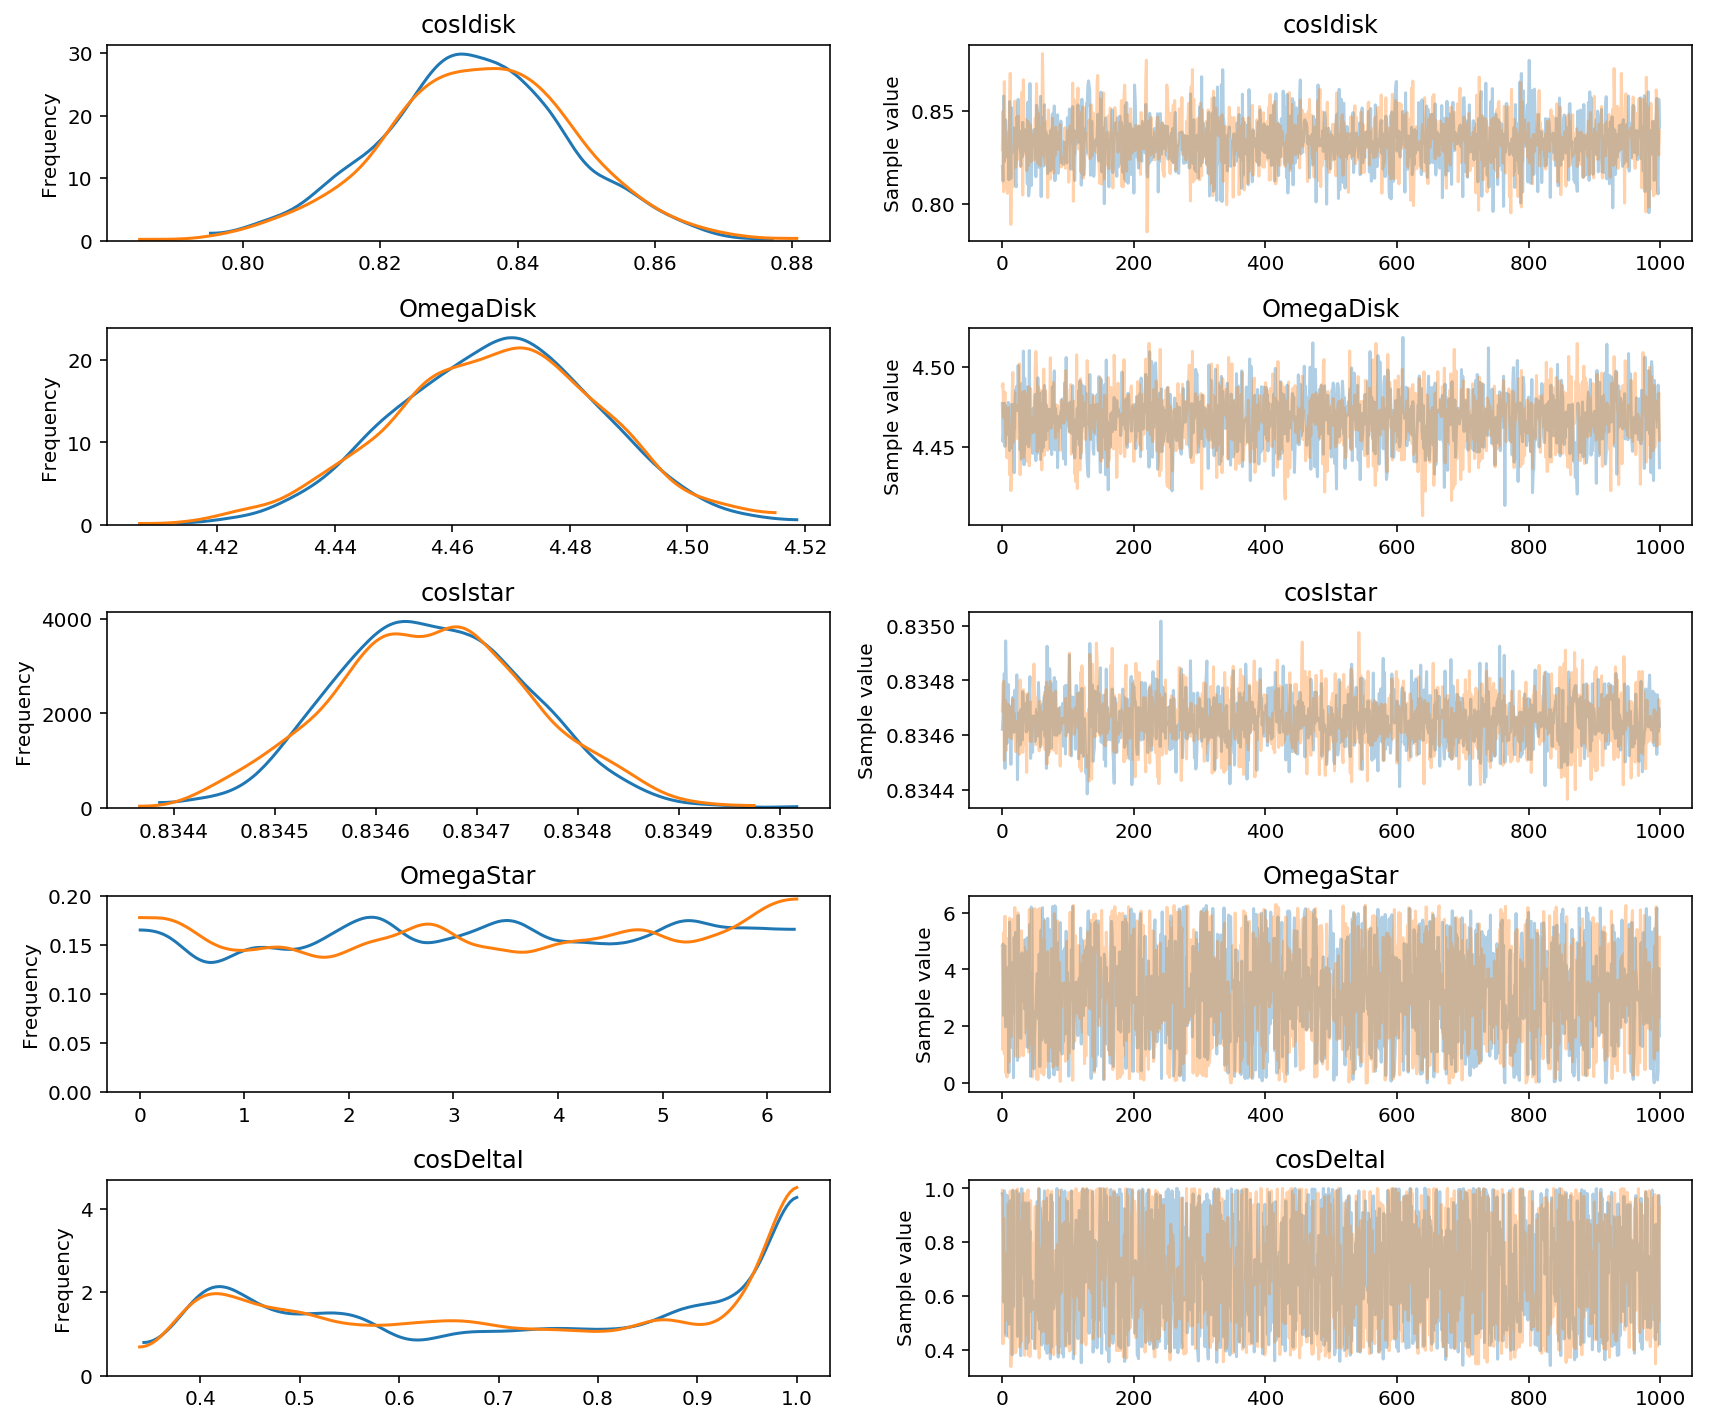

In [6]:
# visualize the output
pm.traceplot(trace)

From these diagnostics, we have good confidence that the MCMC algorithm converged to the target distribution. Now, let's convert these samples back to the actual angles in degrees so we have a better chance of understanding what the mutual inclination posterior looks like.

In [8]:
samples = pm.trace_to_dataframe(trace, varnames=["cosIdisk", "OmegaDisk", "cosIstar", "OmegaStar", "cosDeltaI"])

# create a new dataframe with columns in the right units
asamples = samples.copy()
asamples.rename(index=str, columns={"cosIdisk":"iDisk", "cosIstar":"iStar", "cosDeltaI":"deltaI"}, inplace=True);

# a small function to convert from cos(parameter) to parameter in degrees
icos2deg = lambda x: np.arccos(x)/deg

asamples["iDisk"] = asamples["iDisk"].apply(icos2deg)
asamples["OmegaDisk"] = asamples["OmegaDisk"] / deg
asamples["iStar"] = asamples["iStar"].apply(icos2deg)
asamples["OmegaStar"] = asamples["OmegaStar"] / deg
asamples["deltaI"] = asamples["deltaI"].apply(icos2deg)

In [10]:
# plot up the distribution using DFM's corner package
import corner  

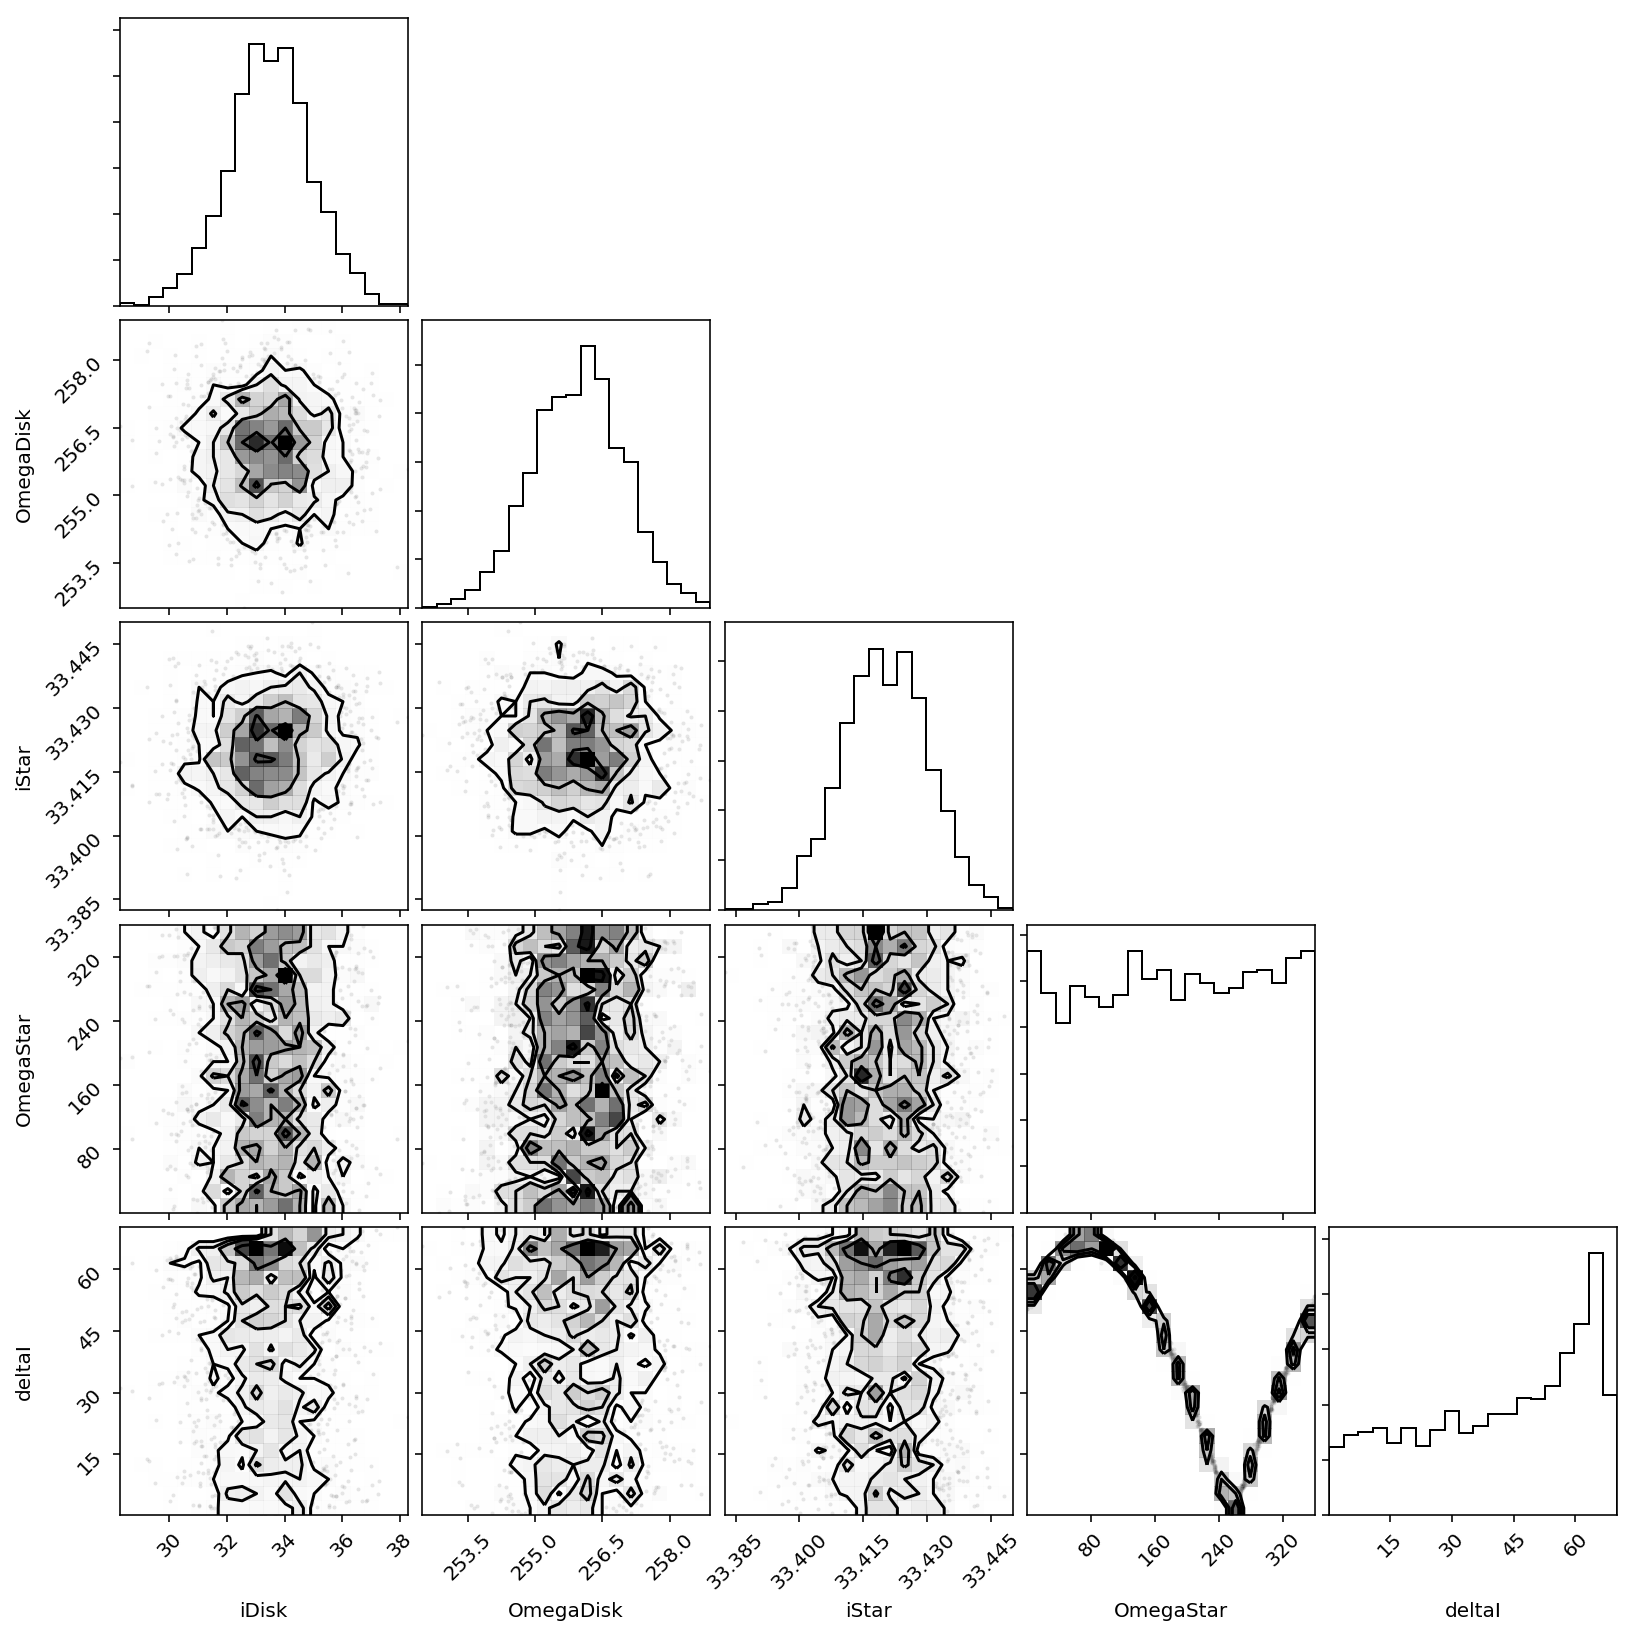

In [12]:
corner.corner(asamples);

This 5-parameter histogram gives a great view on what's going on with this model (all quantities are in degrees here). The first three parameters are the ones we have measurements for, and so we can see that the marginal posteriors of these parameters match the constraints from the data. We had no data to constrain $\Omega_\star$, and so this posterior looks just like the uniform prior that we put on it. The fifth parameter, $\Delta I$, is a deterministic calculation from the previous four parameters. Interestingly, it's broad and spans from 0 degrees up until about 70 degrees.

To see why this behavior arises, consider the 4th panel in the very bottom row, which is the joint posterior of $\Delta I$ and $\Omega_\star$. Because $\Omega_\star$ is unconstrained, as we clock this parameter around [0, 360] degrees, we can generate quite significant $\Delta I$. In retrospect, this all makes a lot of sense. If we think of a unit sphere with the observer above the north pole and we have measured $i_\mathrm{disk} \approx i_\star$, all we can say is that the unit angular moment vectors of the disk and the binary point near the same latitude. 

To really drive this point home, let's say you are in Montreal, Canada, at a latitude of 45.50 deg N, and a longitude of 75.57 deg W. Your friend sees you post something about this to your social media feed and he get's in touch and says "Hey, *I'm* at 45.46 deg N, why don't you come over and we'll grab a coffee?" Without knowing anything about your friend's longitude (i.e., a uniform prior), he could *just as likely* be in Milan, Italy (which is also at 45.50 N) as he is in metropolitan Montreal. To find out how far of a drive away he is, you need to know his longitude.

The "just as likely" part is key here, and explains why the posterior on mutual inclination looks the way it does. Without knowing anything about latitute (or $\Omega_\star$) there's usually plenty of space available on the globe to be situated a far drive away. The maximum possible driving distance decreases as we head to the poles: if both of us knew our latitude to be 89.9 degrees N, regardless of what our longitudes are we could be at most 14 miles away from each other. 

This conclusion is sobering but also feels somewhat unsatisfactory in the context of our circumbinary disk measurements. After the initial excitement of measuring $i_\mathrm{disk} \approx i_\star$ and thinking that these planes must be nearly coplanar, we're reminded at the end of the day that if we're being honest, we can't really report anything other than a maximum limit on their misaligment.

This isn't the full story, and I think the reason the result feels unsatisfactory is illustrated by the following thought experiment. Say we had a sample of 10 disks, and we measured $i_\mathrm{disk} \approx i_\star$ for all of them. We would suspect that there is some sort of alignment in 3D space, because if there wasn't, we would have already seen at least a few disks with $i_\mathrm{disk} \ne i_\star$ in this sample. So, for the purposes of inferring the mutual inclination distribution for all circumbinary disks, lumping together individual estimates of $p(\Delta I)$ is clearly not the right way to go. One way to infer the mutual inclination distribution is to do literally that using a hierarchical Bayesian model for the full population of disks.

# Hierarchical modeling 

One way to think about hierarchical Bayesian modeling is that we're going to repeat the exercise in the first part of the notebook for every disk in our sample simultaneously. And, instead of just assuming that the prior on the orientation of the binary relative to the disk is random, we'll parameterize this prior with some flexible funcitonal form and see if we can actually infer it as well. 

The first step is to assume some functional form for our mutual inclination distribution $p({\Delta I})$, which describes the frequency of systems with that $\Delta I$. Possible distributions include the [beta](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Beta), the [Weibull](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Weibull), and the [gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma).

Since we're talking about spherical geometry, a desirable quality of this mutual inclination distribution is that (regardless of whether mutual inclinations are in general low or high) it obeys

$$
\lim_{\Delta I \to 0^\circ} p(\Delta I) = 0
$$

To understand why, think about pointing a telescope at a target at $(\alpha, \delta)$. There will always be some (small) pointing error, so we actually point at $(\alpha + \epsilon_\alpha, \delta + \epsilon_\delta)$. This means that there will *always* be some *positive* radial pointing error $\epsilon_\rho = \sqrt{\epsilon_\alpha^2 + \epsilon_\delta^2}$, and so there should be 0 probability that we point *exactly* at $(\alpha, \delta)$. For the same reason, the criterion also applies for pointing in the exact opposite direction

$$
\lim_{\Delta I \to 180^\circ} p(\Delta I) = 0
$$

## Parameterizing the mutual inclination distribution 

A common go-to functional choice among hierarchical Bayesians is the $\beta$ distribution, since it's very flexible and has only two parameters, $\alpha$ and $\beta$. The fact that convention states one of the parameters of the $\beta$ distribution is also named $\beta$ is super confusing, so in what follows we'll use $p_\beta$ to refer to the distribution in equations. (We have the power to define our own custom function within [PyMC3/Theano](https://docs.pymc.io/Probability_Distributions.html), but let's see what we can do with the built in functions first.)
 The probability density function (PDF) of the $\beta$ function is 

$$
p_\beta(x |\, \alpha, \beta) = \frac{x^{\alpha - 1}(1 - x)^{\beta - 1}}{B(\alpha, \beta)}
$$
where
$$
B(\alpha, \beta) = \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha + \beta)}
$$

and $p_\beta$ is defined over the range $[0,1]$. From the PDF, we see that if we enforce a prior that $\alpha > 1$ and $\beta > 1$, then this will give us the behavior that the probability goes to zero at the edges of the domain. As an example, here is a range of $p_\beta$ for a range of $\alpha$ and $\beta$ values. 



In [28]:
import itertools

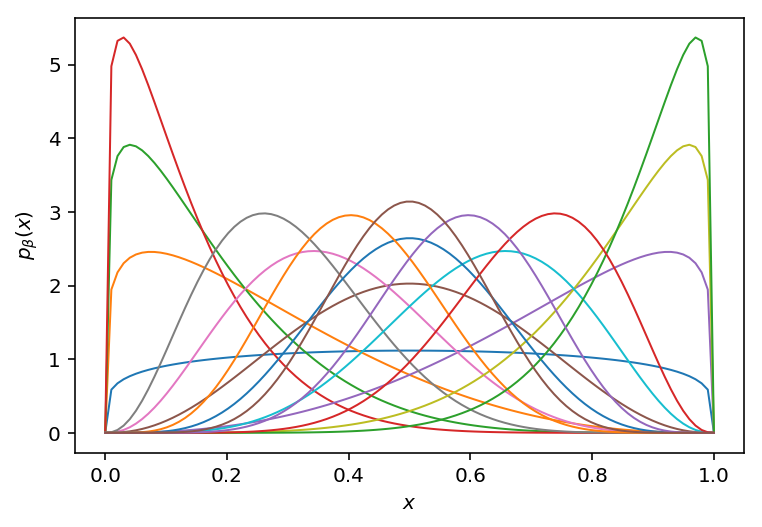

In [29]:
alphas = np.linspace(1.2, 8.0, num=4)
betas = np.linspace(1.2, 8.0, num=4)

xs = np.linspace(0, 1, num=100) # inputs 

fig, ax = plt.subplots(nrows=1)

for alpha,beta in itertools.product(alphas, betas): # plot all combinations
    y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
    ys = np.exp(np.array([y.logp(x).eval() for x in xs]))
    ax.plot(xs, ys, lw=1.0)
    
ax.set_xlabel(r"$x$");
ax.set_ylabel(r"$p_\beta(x)$");

Now that we've established that the $\beta$ distribution is a promising parameterization of our mutual inclination distribution, we need to interface it to our actual problem. This involves transforming the variable $\Delta I$ into something that fits the range $[0, 1]$. The true domain of $\Delta I$ is [0,180] degrees. We can use the variable $\cos\Delta I$, which ranges from $[-1, 1]$, and then multiply it by $1/2$ to shoehorn it into the right domain. We have

$$
x = 0.5 (1 - \cos \Delta I)
$$

where $x = 0$ is completely aligned and $x = 1$ is anti-aligned (the negative sign in front of $\cos$ is to keep the intuitive behavior that low $x$ corresponds to low $\Delta I$). Through this change of parameters we also need to conserve probability

$$
p(x)\,\mathrm{d}x = p(\Delta I)\,\mathrm{d} \Delta I
$$

where

$$
\mathrm{d}x = -0.5 \sin(\Delta I)\,\mathrm{d}\Delta I
$$

To put this all together, we'll say that the modified mutual inclination $x$ for any particular system is drawn from the distribution of mutual inclinations 

$$
x \sim p_\beta(\alpha, \beta)
$$

When we're doing a fit of the orbital parameters of an individual system $k$, this means we'll have prior of

$$
p_k(x_k| \alpha, \beta) = p_\beta(x_k | \alpha, \beta)
$$

In the space of $\Delta I$, this prior is 

$$
p_k(\Delta I) = p_k(x_k| \alpha, \beta) \frac{\mathrm{d}x}{\mathrm{d}\Delta I} = 0.5 p_\beta(0.5(1 - \cos \Delta I) | \alpha, \beta) \sin(\Delta I)
$$

## Fitting a system hierarchically 

Let's revisit the posterior distribution for the mutual inclination of a single system $k$ with this new prior. As before, our likelihood function is conditioned on all four of the quantities required to measure $\Delta I$ (and their covariances, $\boldsymbol{\Sigma}$), but is actually evaluated against only the three quantities we can measure

$$p_k( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star ) = {\cal N}( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star, \boldsymbol{\Sigma})$$

Now, rather than assuming geometric priors on $p(i, \Omega)$ for the disk and binary, we want to use the information from the $\Delta I$ prior we just specified. The mutual inclination distribution says that one plane *relative to the other* is supposed to be some value or other. So, we'll need a reference point. We'll keep the isotropic prior on the orientation of the disk, 

$$
p_k(i_\mathrm{disk}, \Omega_\mathrm{disk}) = 0.5 \sin(i_\mathrm{disk})
$$

and, instead of imposing the same prior on $i_\star$ and $\Omega_\star$, we'll use these values along with the values of $i_\mathrm{disk}$ and $\Omega_\mathrm{disk}$ to calculate $\Delta I$ and impose the mutual inclination prior $p_k(\Delta I)$. All together, the full prior is

$$
p_k(i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star) = 0.5 \sin(i_\mathrm{disk}) p_k(\Delta I(i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star))
$$

As you might have suspected all along, because we don't know anything about $\Omega_\star$, whatever value we measure for $\Omega_\mathrm{disk}$ is actually irrelevant to the problem. The main quantity of interest for the mutual inclination formula is the difference between the two $\Delta \Omega = \Omega_\mathrm{disk} - \Omega_\star$. We can remove one variable from the problem if we just use $\Delta \Omega$. However, just because we had uniform priors on $\Omega_\mathrm{disk}$ and $\Omega_\star$ doesn't mean we have a uniform prior on $\Delta \Omega$. In fact, we have a  "triangle" prior on $\Delta \Omega$, which is the result of the convolution of two top-hat functions on $\Omega_\mathrm{disk}$ and $\Omega_\star$. We can see this with a simple example

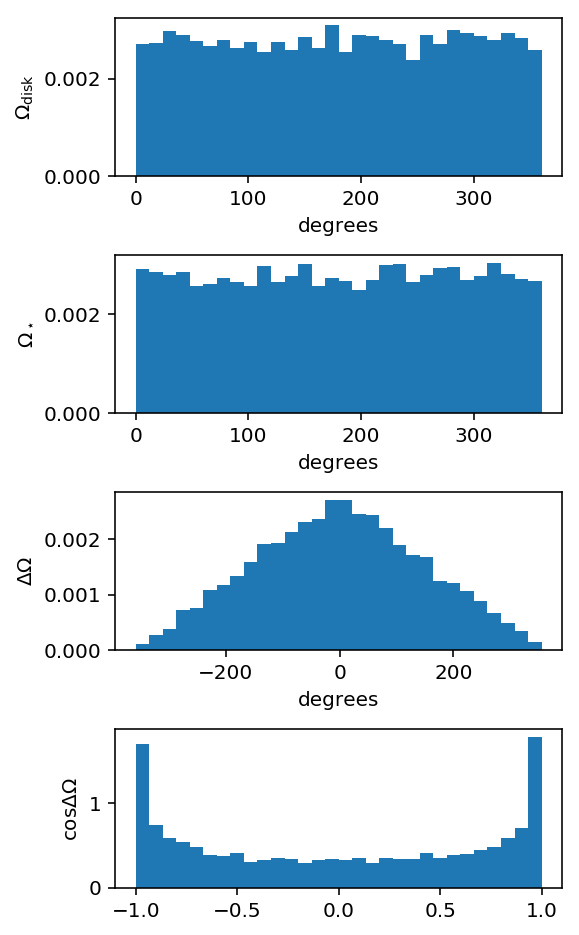

In [18]:
# generate random Omegas
Omega_disk = np.random.uniform(0, 2*np.pi, size=10000)
Omega_star = np.random.uniform(0, 2*np.pi, size=10000)
Delta_Omega = Omega_disk - Omega_star
cosDelta = np.cos(Delta_Omega)

fig, ax = plt.subplots(nrows=4, figsize=(4,8))

bins=30
ax[0].hist(Omega_disk/deg, bins=bins, density=True);
ax[1].hist(Omega_star/deg, bins=bins, density=True);
ax[2].hist(Delta_Omega/deg, bins=bins, density=True);
ax[3].hist(cosDelta, bins=bins, density=True);
for a,ylabel in zip(ax,[r"$\Omega_\mathrm{disk}$", r"$\Omega_\star$", r"$\Delta \Omega$", r"$\cos \Delta \Omega$"]):
    a.set_ylabel(ylabel)

for a in ax[:3]:
    a.set_xlabel("degrees")

fig.subplots_adjust(hspace=0.5)

The form of the triangle prior is just the third panel of the plot, 

$$
p(\Delta \Omega) =  \frac{1}{2 \pi} \left (1 -  \frac{|\Delta \Omega|}{2 \pi} \right )
$$

If we wanted to, we could even bring this prior all the way to a prior on $\cos(\Omega_\mathrm{disk} - \Omega_\star)$ via another transformation of variables, since that's what appears in the mutual inclination formula. 

Keeping in mind the relative nature of the problem, we can rewrite the mutual inclination prior into a form that's a little bit more useful. Given $i_\mathrm{disk}$ and $\Delta \Omega$, through the mutual inclination formula, the prior on $\Delta I$ translates into a prior on $i_\star$

$$
p(i_\star | i_\mathrm{disk}, \Delta \Omega)
$$

Now we can write the final posterior for a disk $k$ as

$$
p_k(i_\mathrm{disk}, i_\star, \Delta \Omega | ) = {\cal N}(\hat{i}_\mathrm{disk}, \hat{i}_\star | i_\mathrm{disk}, i_\star, \boldsymbol{\Sigma}, \Delta \Omega) p(i_\star | i_\mathrm{disk}, \Delta \Omega) p(i_\mathrm{disk}) p(\Delta \Omega) 
$$

As before, given samples from this posterior of the quantities $i_\mathrm{disk}, i_\star, \Delta \Omega$, we can use the mutual inclination formula to directly convert these to a posterior on $\Delta I$. Of course, something that's different in this new setup is that the prior $p(i_\star | i_\mathrm{disk}, \Delta \Omega)$ actually has it's own variables. Remember that we derived this term from the prior distribution of mutual inclinations, which we parameterized with a $\beta$ distribution $p_\beta(\Delta I |\, \alpha, \beta)$. With the full sample of disks, we will seek to infer $\alpha$ and $\beta$ as well. This is the hierarchical nature of the problem.

# Generating fake data

Great, we have a road map of how we'd like to go about inferring the mutual inclination distribution in a hierarchical fashion. To unit test our hierarchical model, let's create a few fake data tests to see how well we can recover *known* distributions. We'll try out this formalism on at least two different fake datasets generated with different underlying mutual inclination distributions. 

1. A distribution with random isotropic binary orbits
2. A distribution with low mutual inclinations

To keep the comparison consistent, we'll first randomly draw disk parameters and then keep these fixed for both comparisons. 

In [189]:
np.random.seed(42)
N_systems = 10

# let's get a sample of uniformly oriented disks in 3D space 
# Generate randomly oriented momentum vector on the sky.
U = np.random.uniform(size=N_systems)
V = np.random.uniform(size=N_systems)

# spherical coordinates for angular momentum vector, uniformly distributed.
i_disks = np.arccos(2 * V - 1.0) / deg # polar angle
Omega_disks = 2 * np.pi * U / deg # azimuth

## Random isotropic binary orbits

Generating the first distribution of binary orbits is pretty easy, these will be drawn from the same isotropic distributions as generated the disks. 

In [190]:
# draw new random numbers 
U = np.random.uniform(size=N_systems)
V = np.random.uniform(size=N_systems)

# spherical coordinates for angular momentum vector, uniformly distributed.
i_star_isos = np.arccos(2 * V - 1.0) / deg # polar angle
Omega_star_isos = 2 * np.pi * U / deg # azimuth


To generate the second distribution, however, requires a tiny bit of vector math and some rotations in spherical coordinates.

## Low mutual inclinations

Let's think about how the binary vector (i.e., the unit angular momentum vector of the orbit) would be oriented relative to the disk vector, given some mutual inclination. Consider two coordinate systems, the one we've been talking about all along (relative to the observer) and a coordinate system relative to the disk (i.e., where the disk vector points to the north pole). The mutual inclination distribution simply specifies the magnitude of the displacement of the binary vector from the disk vector, not the direction. 

To generate binary orbits with low mutual inclinations, in the disk coordinate system

1. Randomly generate a polar angle $\theta = \Delta I$ from the specified distribution of mutual inclinations $p_\beta(\Delta I |\, \alpha, \beta)$
2. Randomly generate an azimuthal angle $\phi$ from [0, 360] degrees. These angles specify the binary unit vector in the disk coordinate system.

Then, using the known orientation of the disk frame (from $i_\mathrm{disk}$ and $\Omega_\mathrm{disk}$) rotate the binary unit vector to the observer frame and record $i_\star$ and $\Omega_\star$.

As "truth," let's assume some mutual inclination distribution that is a Gaussian with $\sigma = 2^\circ$ and mean $5^\circ$, tapered by a $\sin(\Delta I)$ profile. So, we have 

$$
p(\Delta I) \propto \sin(\Delta I) \exp \left ( - \frac{(\Delta I - 5^\circ)^2}{2 (2^\circ)^2} \right)
$$

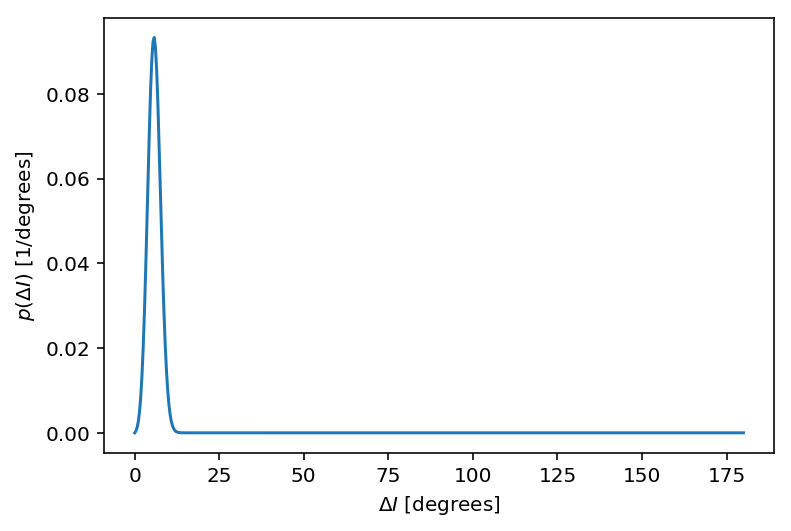

In [48]:
def input_prob(Delta_I):
    '''
    Delta_I is in degrees.
    '''
    return np.sin(Delta_I * deg) * np.exp(-0.5 * (Delta_I - 5.0)**2 / (2**2))

dis = np.linspace(0, 180.0, num=500)
p_is = input_prob(dis)

plt.plot(dis, p_is);
plt.xlabel(r"$\Delta I$ [degrees]");
plt.ylabel(r"$p(\Delta I)$ [1/degrees]");

To generate random samples from this, we could use the inverse cumulative probability distribution method, but because this is a complicated function it's not immediately obvious that an analytical inverse exists. Therefore, we would need to find the inverse of the integral numerically. It's easier (and probably less error prone) to just sample this univariate distribution with some Monte Carlo method. We could use MCMC, but I want to hide the fact that I'm just a hack that resorts to MCMC for everything for as long as I can, so instead we'll use the rejection sampling technique here. Briefly, the technique works by drawing random samples of $\Delta I$ from some proposal distribution (which is chosen as to be easy to generate samples from). The probability of the proposal distribution and target distribution are evaluted for $\Delta I$. The sample is accepted with some probability based upon the ratio of the propsal to the target, and at the end of the day, we're left with samples that reflect the target distribution. It helps efficiency if we can choose a proposal distribution that closely matches the target distribution, but we have to keep in mind that the proposal distribution must be greater than the target distribution for all values of $\Delta I$. For more detail, see the excellent coverage in [MacKay's textbook, Ch 29](http://www.inference.org.uk/itprnn/book.html).

For the proposal distribution $Q(\Delta I)$, we'll just use the Gaussian part of the target distribution, since the $\sin \Delta I$ taper ensures that $Q(\Delta I) > P(\Delta I)$ for all $\Delta I$.

$$
Q(\Delta I) = \exp \left ( - \frac{(\Delta I - 5^\circ)^2}{2 (2^\circ)^2} \right)
$$

In [49]:
# proposal probability 
def propose_prob(Delta_I):
    '''
    Delta_I is in degrees.
    '''
    return np.exp(-0.5 * (Delta_I - 5.0)**2/(2**2))

In [54]:
# proposed values 
DI_props = np.random.normal(loc=5.0, scale=2.0, size=100000)

# since we know that the mutual inclination must be between 0 and 180, let's get rid of any values on the tail 
# of the Gaussian that exceed these ranges 
DI_props = DI_props[(DI_props > 0.0) & (DI_props < 180.0)]

# Evaluate the probability of Q for all samples
Qs = propose_prob(DI_props)

# Generate a random number [0, Q(Delta I)] for all samples 
us = np.random.uniform(low=0, high=Qs)

# Evaluate p(Delta I) for all samples
Ps = input_prob(DI_props)

# Keep the samples for which u <= P
DI_samples = DI_props[us <= Ps]

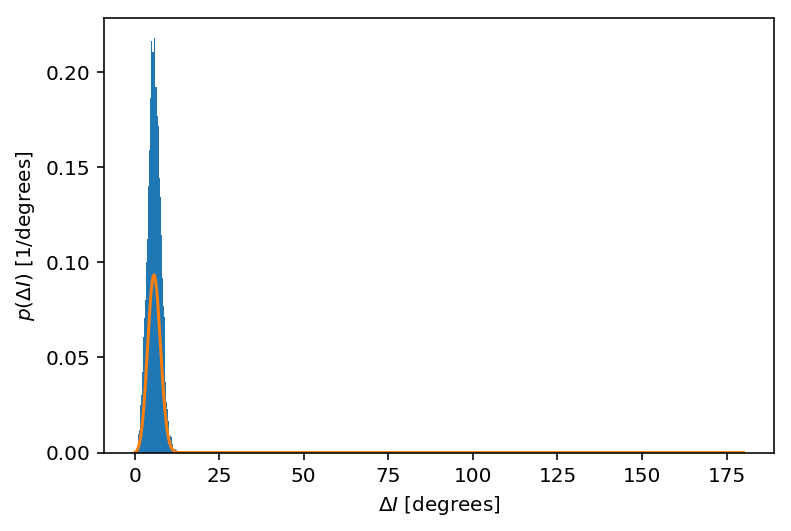

In [55]:
fig, ax = plt.subplots(nrows=1)

ax.hist(DI_samples, bins=50, density=True)
ax.plot(dis, p_is);
ax.set_xlabel(r"$\Delta I$ [degrees]");
ax.set_ylabel(r"$p(\Delta I)$ [1/degrees]");

Great, they match up except for the normalization constant. This is because the actual $p(\Delta I)$ was unnormalized, and so that's why it appears off. The beauty of rejection sampling is that we never need to compute this normalization factor in order to generate samples from the distribution. 

If we wanted to be obsessive about this, we could compute the normalization factor for $p(\Delta I$) numerically and check that they line up exactly.

In [59]:
from scipy.integrate import quad 

norm = quad(input_prob, 0.0, 180.0)

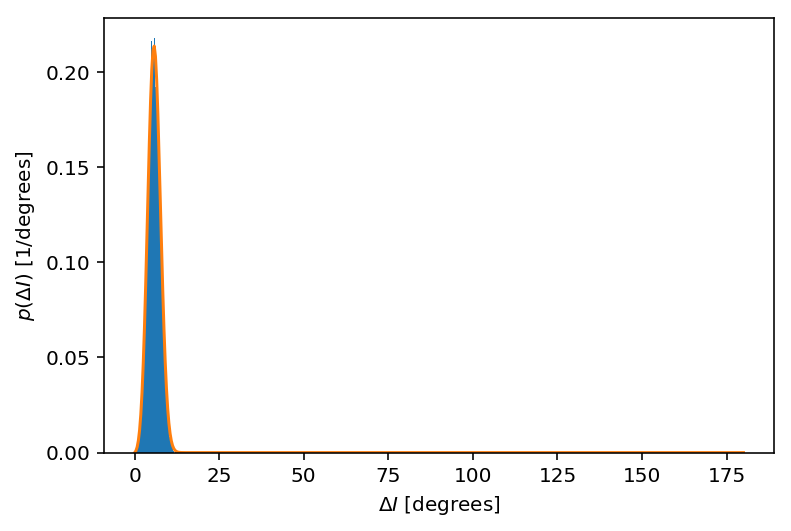

In [62]:
fig, ax = plt.subplots(nrows=1)

ax.hist(DI_samples, bins=50, density=True)
ax.plot(dis, p_is / norm[0]);
ax.set_xlabel(r"$\Delta I$ [degrees]");
ax.set_ylabel(r"$p(\Delta I)$ [1/degrees]");

Now that that's settled, let's create binaries with some degree of misalignment relative to the disk. In the disk frame, we'll set the polar angle ($\theta$) of the binary to be a  mutual inclination chosen from the samples of our mutual inclination distribution, and choose a random direction for the displacement ($\phi$).

In [193]:
thetas = np.random.choice(DI_samples, size=N_systems) # degrees
phis = np.random.uniform(low=0, high=360., size=N_systems) # degrees

Now we'll pair these up with disk parameters and convert them to the sky frame. To go from $\theta$ and $\phi$ in the disk frame ($x,y,z$) to $i_\star$ and $\Omega_\star$ in the observer frame ($X, Y, Z$), we need a series of rotations.

$$
  \boldsymbol{P}_x(\xi) = \left [
  \begin{array}{ccc}
    1 & 0 & 0 \\
    0 & \cos \xi & - \sin \xi \\
    0 & \sin \xi & \cos \xi \\
    \end{array}\right]
$$

$$
  \boldsymbol{P}_z (\xi) = \left [
  \begin{array}{ccc}
    \cos \xi & - \sin \xi & 0\\
    \sin \xi & \cos \xi & 0 \\
    0 & 0 & 1 \\
    \end{array}\right].
$$

These rotation matrices result in a *clockwise* rotation of the axes, as defined using the right hand rule. This means when we look down the $z$ axis, for a positive angle $\xi$, it would be as if the $x$ and $y$ axes rotated clockwise.

Let $X$, $Y$, and $Z$ be the coordinates of the observer frame, with the observer looking down the $Z$ axis, $X$ representing north and $Y$ representing east. In our convention, we assume $\Omega$ is positive in the counter-clockwise direction, i.e., north towards east. Let $x$, $y$, and $z$ be the coordinates of the disk frame, with the $z$ axis being the disk angular momentum unit vector.


In the disk frame, the coordinates of our perturbed binary orbit correspond to 

$$
\left [ \begin{array}{c}
x\\
y\\
z\\
\end{array} \right]
=
\left [ \begin{array}{c}
\sin \theta \cos \phi \\
\sin \theta \sin \phi \\
\cos \theta \\
\end{array} \right]
$$

In [106]:
def P_x(xi):
    '''
    Calculate the transformation matrix about the X-axis. Assumes the angle is in degrees.
    '''
    x = xi * deg
    return np.array([[1, 0, 0], [0, np.cos(x), -np.sin(x)], [0, np.sin(x), np.cos(x)]])

def P_z(xi):
    '''
    Calculate the transformation matrix about the Z-axis. Assumes angle is in degrees.
    '''
    x = xi * deg
    return np.array([[np.cos(x), -np.sin(x), 0], [np.sin(x), np.cos(x), 0], [0, 0, 1]])

def get_xyz(theta, phi):
    '''
    Convert angles in the disk frame into x, y, z in the disk frame. All angles in degrees.
    '''
    return np.array([np.sin(theta * deg) * np.cos(phi * deg), \
                     np.sin(theta * deg) * np.sin(phi * deg), \
                     np.cos(theta * deg)])

To convert the observer frame to the disk frame, first we'll rotate about the $Z$ axis by an amount $\Omega_\mathrm{disk}$ (in the negative, counter-clockwise direction). Then, around the new intermediate $x/X$ axis, we'll rotate by an amount $i_\mathrm{disk}$.

$$
\left [ \begin{array}{c}
x\\
y\\
z\\
\end{array} \right]
=
\boldsymbol{P}_x(i_\mathrm{disk}) \boldsymbol{P}_z(- \Omega_\mathrm{disk}) 
\left [ \begin{array}{c}
X\\
Y\\
Z\\
\end{array} \right]
$$

To convert coordinates in the disk frame into the observer frame, we apply the inverse rotation matrices in the correct order. The inverses are just the transposes of the forward rotation matrices.

$$
\left [ \begin{array}{c}
X\\
Y\\
Z\\
\end{array} \right]
=
\boldsymbol{P}_z^{-1}(- \Omega_\mathrm{disk}) \boldsymbol{P}_x^{-1}(i_\mathrm{disk}) 
\left [ \begin{array}{c}
x\\
y\\
z\\
\end{array} \right]
$$

To convert $X$, $Y$, and $Z$ into $i_\star$ and $\Omega_\star$, we'll just use trigonometry. All along we've been using the unit sphere, so $1 = \sqrt{X^2 + Y^2 + Z^2}$ and 

$$
i_\star = \cos^{-1} (Z)
$$

$$
\Omega_\star = \tan^{-1}(Y / X)
$$

In [196]:
def get_binary_parameters(i_disk, Omega_disk, theta, phi):
    '''
    Using the matrix math above, calculate i_star and Omega_star. Assumes all angles are in degrees.
    '''
    
    xyz = get_xyz(theta, phi)
    
    res = np.dot(P_z(-Omega_disk).T, np.dot(P_x(i_disk).T, xyz))
    
    X, Y, Z = res 
    
    i_star = np.arccos(Z)/deg
    Omega_star = np.arctan2(Y, X)/deg - 90.0 
    # the -90 is because the projection of the angular momentum vector is not the same as the 
    # ascending node
    
    return i_star, Omega_star

Let's generate a bunch of random orbits!

In [197]:
i_stars = np.empty(N_systems, np.float64) # degrees
Omega_stars = np.empty(N_systems, np.float64) # degrees

for i in range(N_systems):
    i_stars[i], Omega_stars[i] = get_binary_parameters(i_disks[i], Omega_disks[i], thetas[i], phis[i]);

In [198]:
# create tables of all of these things as datasets
from astropy.table import Table

In [199]:
# compute the mutual inclination of these too, and add it as a column
iso_sample = Table([i_disks, Omega_disks, i_stars, Omega_stars], names=["i_disk", "Omega_disk", "i_star", "Omega_star"])

In [ ]:
def calc_Delta_I(i_disk, Omega_disk, i_star, Omega_star):
    '''
    Calculate the mutual inclination between two planes.
    '''
    

In [200]:
iso_sample

i_disk,Omega_disk,i_star,Omega_star
float64,float64,float64,float64
163.50227502309326,134.8344427850505,163.64740245412867,-245.6993826950751
19.978699877320064,342.2571503075698,15.461787111072827,-29.676287358739422
48.32647488671633,263.51781905210584,49.73166574802833,-91.31202851473267
125.12216966480769,215.51705431093316,128.05947749114281,-139.49903806794865
129.52018838155797,56.16671055927715,125.52702891012146,47.16016084821587
129.28594162348503,56.158027321032954,122.78674270973649,57.26629214510973
113.04883202952833,20.910100380551807,116.5192680580966,22.940370391894902
87.16196151047119,311.82341247897665,84.07902472908421,-41.5863712310807
97.82280854361962,216.4014042275552,97.22376985004993,-139.18371868721457


In [188]:
get_binary_parameters(20.0, 90.0, 0.0, 0.0)

[0. 0. 1.]
-0.3420201433256687 2.094269368838496e-17 0.9396926207859084


(19.999999999999993, 90.0)

In [60]:
for pair in zip(i_disk, Omega_disk):
    print("i_disk: {:>6.2f} deg, Omega_disk: {:>6.2f} deg".format(*pair))

i_disk: 133.47 deg, Omega_disk: 134.83 deg
i_disk: 152.11 deg, Omega_disk: 342.26 deg
i_disk:  42.92 deg, Omega_disk: 263.52 deg
i_disk:  78.33 deg, Omega_disk: 215.52 deg
i_disk:  65.41 deg, Omega_disk:  56.17 deg


Now, let's choose our two distributions on $\Delta I$. The one with close alignments

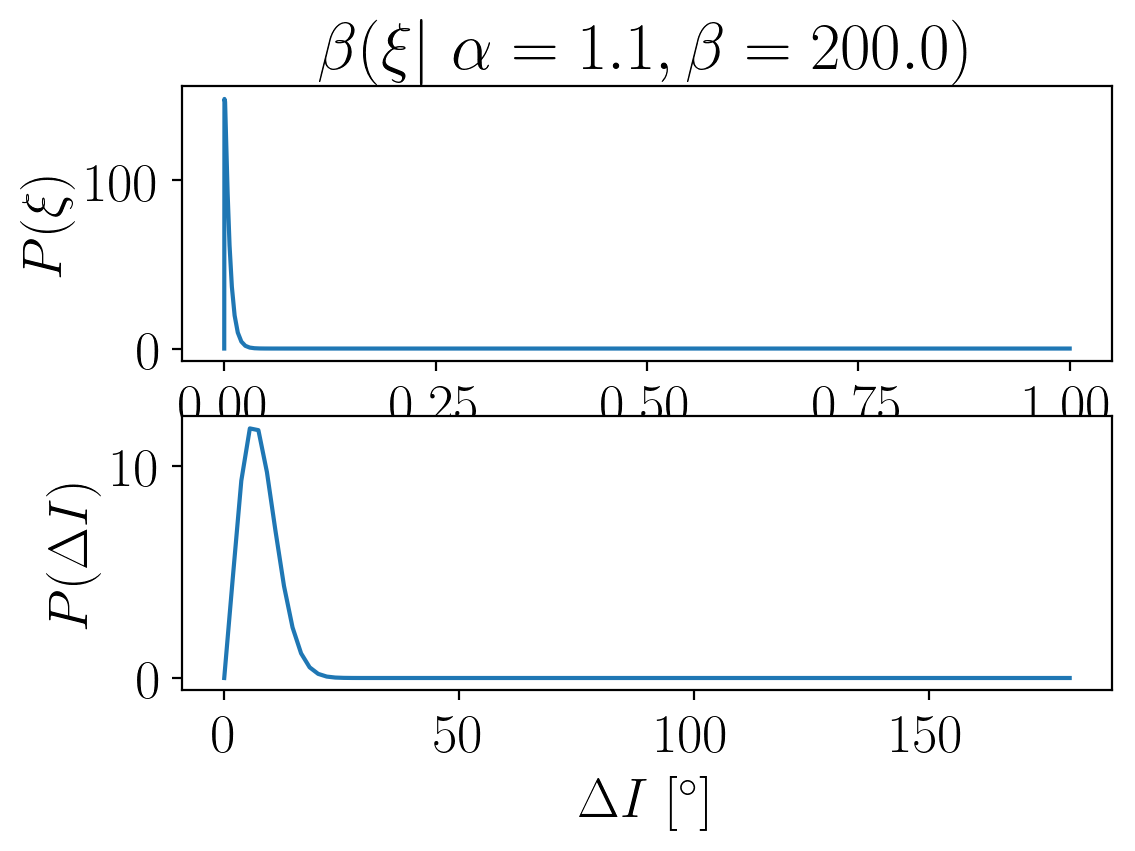

In [79]:
DeltaIs = np.linspace(0.0, 180.0, num=100) # inputs 
xis = 0.5 * (1 - np.cos(DeltaIs * deg))

fig, ax = plt.subplots(nrows=2)

alpha = 1.1
beta = 200.0
y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
ys = np.exp(np.array([y.logp(xi).eval() for xi in xis]))
ax[0].plot(xis, ys)
    
PIs = ys * np.sin(DeltaIs * deg)
ax[1].plot(DeltaIs, PIs)    
    
ax[0].set_xlabel(r"$\xi$");
ax[0].set_ylabel(r"$P(\xi)$");
ax[0].set_title(r"$\beta(\xi |\ \alpha={:.1f}, \beta={:.1f})$".format(alpha, beta));

ax[1].set_ylabel(r"$P(\Delta I)$");
ax[1].set_xlabel(r"$\Delta I$ [${}^\circ$]");

The conversions between the two variables are
$$
\xi = 0.5 (1 - \cos \Delta I)
$$

$$
\Delta I = \cos^{-1}(1 - 2 \xi)
$$
The $\beta$ distribution does OK for this, but I guess I'd like something a bit stronger at lower mutual inclinations and a bit softer at larger mutual inclinations. Anyway, it's probably an OK start to the problem for now.

In [80]:
# let's actually draw from samples from this 
alpha = 1.1
beta = 200.0
y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation

xis = y.random(size=N_systems)
DeltaIs = np.arccos(1 - 2 * xis)/deg    

for pair in zip(xis, DeltaIs):
    print(pair)
    
# Now, assume that the direction of this offset from the vector position of the disk 
# is randomly chosen from 0,360 on the unit sphere
# apply this Delta I offset from this point
# then 

(0.002043184221581926, 5.181486758714563)
(0.00571201449847902, 8.66885216413623)
(0.0008703620281001284, 3.3811591616826626)
(0.014540156307254826, 13.851451118134559)
(0.0018944931765767406, 4.989262730358599)


In [ ]:
# can we also take into account that there are possibly retrograde orbits?